# Coordinate Ascent Variational Inference

Variational Inference (VI) is an approach used to approximate complicated distribution $p(z|x)$. It learn an approximate distribution $q(z)$ by optimization. In this paper, we use Coordinate Ascent Variational Inference (CAVI) to approximate the posterior distribution of a mixture of two 1D Gaussian distribution.

## A. Gaussian Mixture Model

We consider a 1D Gaussian mixture model with prior variance of component means $\sigma^{2}$. The full hierarchical model is

\begin{align}
    \mu_{k} &\sim \mathcal{N}(0, \sigma^{2}), & k=1,\ldots, K\\
    c_{i} &\sim Categorical(1/K, \ldots, 1/K), & i=1, \ldots, n\\
    x_{i}|c_{i}, \mu &\sim \mathcal{N}(c_{i}^{T}\mu, 1) & i=1, \ldots, n
\end{align}


, and the mean-field variational family instead

\begin{align}
q(\mu, c) = \prod_{k=1}^{K}q(\mu_{k};m_{k}, s_{k}^{2})\prod_{i=1}^{n}q(c_{i};\varphi_{i})
\end{align}


## B. ELBO

The Evidence Lower Bound (ELBO) to maximize is

\begin{align}
    &ELBO(m, s^{2}, \varphi) = \sum_{k=1}^{K}\mathbb{E}\big[\log p(\mu_{k});m_{k}, s_{k}^{2}\big]\\
    &+\sum_{i=1}^{n}\bigg(\mathbb{E}\big[\log p(c_{i});\varphi_{i}\big]+\mathbb{E}\big[\log p(x_{i}|c_{i}, \mu);\varphi_{i},m, s^{2}\big]\bigg)\\
    &-\sum_{i=1}^{n}\mathbb{E}\big[\log q(c_{i};\varphi_{i})]-\sum_{k=1}^{K}\mathbb{E}\big[\log q(\mu_{k};m_{k}, s_{k}^{2})]
\end{align}

Using that $q(\mu_{k}; m_{k}, s_{k}^{2}) = \mathcal{N}(\mu_{k};m_{k}, s_{k}^{2})$ and $q(c_{i};\varphi_{i})=Cat(c_{i};\varphi_{i})$ the ELBO can be written as

\begin{align}
    &ELBO(m, s^{2}, \varphi) = -\frac{1}{2\sigma^{2}}\sum_{k=1}^{K} m_{k}^{2}+s_{k}^{2}-\frac{1}{2}\log 2\pi\sigma^{2}\\
    &-n\log K+\sum_{i=1}^{N}\sum_{k=1}^{K}\varphi_{ik}(m_{k}x_{i}-\frac{m_{k}^{2}+s_{k}^{2}}{2})\\
    &-\frac{1}{2}\sum_{i=1}^{n}x_{i}^{2}-\frac{n}{2}\log 2\pi \\
    &-\sum_{i=1}^{n}\sum_{k=1}^{K}\varphi_{ik}\log \varphi_{ik}-\frac{1}{2}\sum_{k=1}^{K}\log s_{k}^{2}
\end{align}

, and can be simplified to 

\begin{align}
    &ELBO(m, s^{2}, \varphi) = -\frac{1}{2\sigma^{2}}\sum_{k=1}^{K} m_{k}^{2}+s_{k}^{2}\\
    &+\sum_{i=1}^{N}\sum_{k=1}^{K}\varphi_{ik}(m_{k}x_{i}-\frac{m_{k}^{2}+s_{k}^{2}}{2})\\
    &-\sum_{i=1}^{n}\sum_{k=1}^{K}\varphi_{ik}\log \varphi_{ik}-\frac{1}{2}\sum_{k=1}^{K}\log s_{k}^{2}\\
    &+const
\end{align}

, so we can omit the constant.

## C. CAVI

Below the particular CAVI algorithm:




**input**: Data $x_{1:n}$, number of components $K$, prior variance of component means $\sigma^{2}$<br>
**output**: Variational densities $q(\mu_{k};m_{k},s_{k}^{2})$(Gaussian) and $q(c_{i};\varphi_{i})$ (K-categorical)<br>
**initialize**: Variational parameters $m=m_{1:K}$, $s^{2}=s_{1:K}^{2}$, and $\varphi=\varphi_{1:n}$<br>
**while** the ELBO has not converged **do**<br>
- **for** $i \in\{1,\ldots, n\}$ **do**<br>
\begin{align}
\alpha_{ik} = \exp\big(m_{k}x_{i}-\frac{m_{k}^{2}+s_{k}^{2}}{2}\big)
\end{align}
\begin{align}
\phi_{ik} = \frac{\alpha_{ik}}{\sum_{k=1}^{K}\alpha_{ik}}
\end{align}
    **end**<br>
- **for** $k \in \{1, \ldots, K\}$ **do**<br>
\begin{align}
m_{k} = \frac{\sum_{i=1}^{n}\varphi_{ik}x_{i}}{1/\sigma^{2}+\sum_{i=1}^{n}\varphi_{ik}x_{i}}
\end{align}
\begin{align}
s_{k}^{2} = \frac{1}{1/\sigma^{2}+\sum_{i=1}^{n}\varphi_{ik}x_{i}}
\end{align}
     **end**<br>
     Compute ELBO($m, s^{2}, \varphi$)<br>
     
**end**


The convergence criterion used is $ELBO_{i}-ELBO_{i-1}<tol$ and $ELBO_{i}-ELBO_{i-1}\geq 0$, where $tol$ means the numerical tolerance, in this case it was set to $1e-16$. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import norm, uniform, beta, bernoulli, multinomial, dirichlet, gamma

import warnings
warnings.filterwarnings("ignore")

plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

In [11]:
def cavi_gmm(x, K, sigma2, m=None, s2=None, phi=None, max_iter=100, tol=1e-16, seed=0):
    def compute_elbo(x, sigma2, m, s2, phi):
        ms2 = (m**2+s2)/2
        term1 = -ms2.sum()/sigma2
        term2 = np.dot(np.dot(x, phi),m)-(phi*ms2).sum()
        term3 = - (np.nan_to_num(phi*np.log(phi))).sum()
        term4 = -np.log(s2).sum()/2
        return term1+term2+term3+term4

    ti = time()
    # number of observations
    n = len(x)
    # generate init parameters if are not given
    np.random.seed(seed)
    if m is None:
        m = norm.rvs(loc=0,scale=sigma2**0.5,size=K)
    if s2 is None:
        s2 = gamma.rvs(1,1,size=K)
    if phi is None:
        phi =  dirichlet.rvs(np.ones(K),n)

    # loss
    elbo = []
    
    # init counter
    j=0
    elbo0 = 1e-16
    while (j<max_iter):
        # update phi
        for i in range(0, n):
            for k in range(1, K):
                phi[i,k] = np.exp(m[k]*x[i]-(s2[k]+m[k]**2)/2)
            phi[i] = phi[i]/phi[i].sum()
        # update m
        for k in range(0,K):
            aux_value = (1/sigma2+phi[:,k].sum())
            m[k] = np.dot(phi[:,k],x)/aux_value
            s2[k] = 1/aux_value
        # compute elbo
        elbo1 = compute_elbo(x, sigma2, m, s2, phi)
        elbo.append(elbo1)
        # convegence criteria
        if (elbo1-elbo0<tol) and (elbo1-elbo0>=0):
            break
        else:
            elbo0 = elbo1
        # update counter
        j +=1
    tf = time()
    return   {"elbo":elbo, "m":m, "s2":s2, "phi":phi, "t":tf-ti, "iter": j, "n":n}

## D. Data

In this section is explained the process used to generate the data. Firstly, was setted the number of components to discover in $K=2$ and the prior variance of component means in $\sigma^{2}=100$. Secondly, two means are sampled using $\mu_{k}\sim \mathcal{N}(0, \sigma)$. The means gotten are $\mu_{1}=2.210$ and $\mu_{2}=-3.405$. Thirdly, the mixtures components are sampled using $\pi\sim Dir(1_{K})$ and the clusters assignments from $c_{i}\sim Cat(\pi)$ with $i \in {1\,\ldots, n}$, where the sample size $n$ is not fixed. The $\pi$ gotten is $[0.656, 0.344]$. Finally, the data is sampled using $x_{i}|c_{i}, \mu \sim \mathcal{N}(c_{i}^{T}\mu, 1)$. It is ilustrated in Figure 1 using a sample size $n=10000$. 

In [6]:
def sampling(n=100, seed=12345, sigma2=100, K=2):
        np.random.seed(seed)
        mu = norm.rvs(loc=0, scale=sigma2**0.5, size=K)
        p = dirichlet.rvs(np.ones(K),1)[0]
        c = multinomial.rvs(p=p, size=n, n=1)
        x = np.array([norm.rvs(np.dot(c[i], mu), 1) for i in range(n)])
        return mu, p, c, x

In [7]:
# sampling mixture of two normal
sigma2 = 100
mu, pi, c, x = sampling(n=10000, seed=19, sigma2=sigma2, K=2)
print(mu, pi)

[ 2.21003263 -3.40465009] [0.65610367 0.34389633]


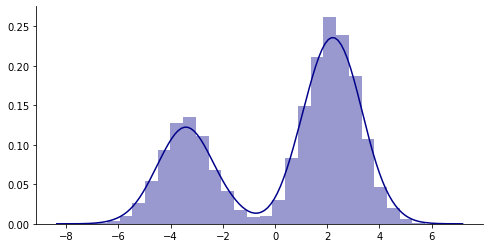

In [8]:
fig1, axs = plt.subplots(1, 1, figsize=(8,4))
sns.distplot(x, ax=axs,  color="darkblue")
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
plt.show()

**Figure 1:** Random sample of a mixture of two Gaussians with sample size $n=10000$.

In [509]:
fig1.savefig("img/data.pdf")

## E. ELBO convergence


This section shows ELBO's convergece in function of different samples sizes and initial parameters. The ELBO's convergence for different sample sizes is illustrated in Figure 2. The initial variational parameters used are the same, they are $m_{k} = 0$ (the prior mean), $s_{k}=1$ and $\phi_{ik}=1/K$. In this figure it is observed that the greater sample size takes less iterations in converge. However, a larger sample size implies more expensive iterations. The behavior of the ELBO's convergence for different initial variational parameter is shown in Figure 3. The sample size used are the same and is $n=100$. In this figure it is observed that different initialization of the variational parameters may lead CAVI to find different local optima of the ELBO.

In [12]:
outputs = []
for n in [10, 20, 50, 100]:
    # init parameters
    K = 2
    sigma2 = 100
    m = np.zeros(K)
    s2 = np.ones(K)
    phi = np.ones((n, K))/K 
    # sampling mixture of two normal
    mu, pi, c, x = sampling(n=n, seed=19, sigma2=sigma2, K=K)
    # cavi
    output = cavi_gmm(x=x, K=K, sigma2=sigma2, m=m, s2=s2, phi=phi, max_iter=1000)
    outputs.append(output)

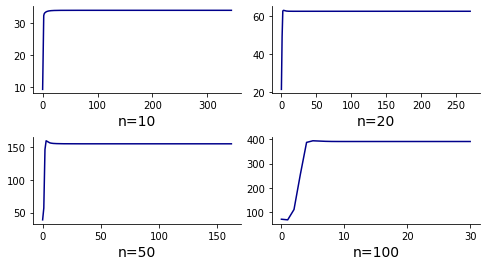

In [13]:
fig2, axs = plt.subplots(2, 2, figsize=(8,4))
plt.subplots_adjust(hspace=0.5, wspace=0.15)
data_size = [[10, 20], [50, 100]]
elbos = [outputs[i]["elbo"] for i in [0,1,2,3]]
for i in range(2):
    for j in range(2):
        axs[i,j].plot(elbos[i*2+j], color="darkblue")
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].set_xlabel(f"n={data_size[i][j]}")
plt.show()

**Figure 2:** Iteration that the ELBO takes to converge for different sample sizes.

In [44]:
fig2.savefig("img/elbo_sample.pdf")

In [14]:
m = outputs[-1]["m"]
s2 = outputs[-1]["s2"]
p = outputs[-1]["phi"].mean(axis=0)
print(m, s2, p)

[ 2.0635241  -3.68941219] [0.01591918 0.02687978] [0.62807308 0.37192692]


In [41]:
elbos = []
for seed in range(0, 20):
    elbos.append(cavi_gmm(x, K, sigma2, 
                          m=None, s2=None, phi=None, max_iter=25, tol=1e-16, seed=seed)["elbo"])

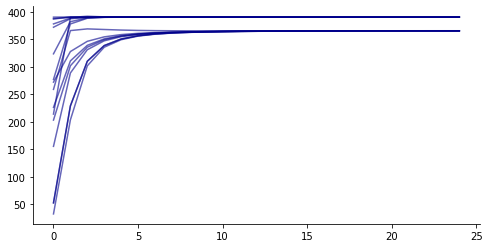

In [42]:
fig3, axs = plt.subplots(1, 1, figsize=(8,4))
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)  
for elbo in elbos:
    if len(elbo)>=10:
        axs.plot(elbo, color="darkblue", alpha=0.6)
plt.show()

In [43]:
fig3.savefig("img/elbo_init.pdf")

## F. CAVI approximation

The mean-field approximation is shown in Figure 4. In this figure can be senn that the mean-field approximation underestimate the posterionr variance. This is consequence of its objective function, since it penalizes more to put mass in regions where $p(z|x)$ has no mass. Despite underestimating the variance, the approximation is quite good, where for a sample size $n=100$ the expected value of the means are $\mathbb{E}(\mu_{1}) = 2.064$ and $\mathbb{E}(\mu_{2})=-3.689$, very close to the means used to generate the data.

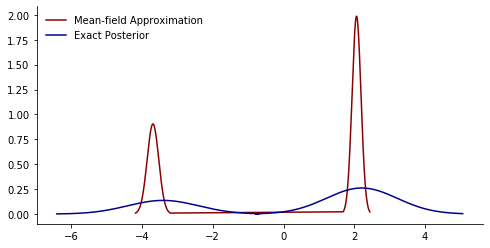

In [15]:
xqs = []
yqs = []
xps = []
yps = []

for k in range(K-1, -1, -1):

    xq = np.linspace(m[k] - 3*s2[k]**0.5, m[k] + 3*s2[k]**0.5, 1000)
    yq = p[k]*norm.pdf(xq, m[k], s2[k]**0.5)
    
    xp = np.linspace(mu[k] - 3, m[k] + 3, 1000)
    yp = pi[k]*norm.pdf(xp, mu[k], 1)
    
    xqs.append(xq)
    yqs.append(yq)
    xps.append(xp)
    yps.append(yp)
    
xq = np.concatenate(xqs)
yq = np.concatenate(yqs)
xp = np.concatenate(xps)
yp = np.concatenate(yps)

fig4, axs = plt.subplots(1, 1, figsize=(8,4))

axs.plot(xq, yq, color="darkred", label="Mean-field Approximation")
axs.plot(xp, yp, color="darkblue", label="Exact Posterior")
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)  
plt.legend(frameon=False)
plt.show()

**Figure 4**: Mean-field approximation of a Gaussian mixture model.

In [529]:
fig4.savefig("img/cavi_approx.pdf")